## Set up packages and Kaggle connection

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import xgboost as xgb
from lightgbm import LGBMClassifier
from scipy.stats import jarque_bera
from scipy.special import logit, expit

/opt/anaconda3/envs/tf2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
import seaborn as sns
import gc
import logging
import datetime
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/tf2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay,precision_recall_curve, plot_roc_curve, classification_report
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn.naive_bayes import CategoricalNB,GaussianNB

import scikitplot as skplt
import tensorflow as tf 
import random

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jacobbraun","key":"392939438edcd0495f527be30174d4ca"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c santander-customer-transaction-prediction

 99% 247M/250M [00:03<00:00, 80.1MB/s]
100% 250M/250M [00:03<00:00, 68.2MB/s]


In [5]:
!unzip santander-customer-transaction-prediction

Archive:  santander-customer-transaction-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Data Exploration

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Check for missing values:

In [7]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

Isolate the features (drop ID_code and outcome variable)

In [8]:
x_train = train.drop(['ID_code', 'target'], axis=1)
x_test = train.drop(['ID_code'], axis=1)

Check correlation matrices in the training and testing sets

In [9]:
# Create a correlation matrix for the features
corr_mat = x_train.corr()
# Fill the diagonal with 0's since each variable is correlated with itself
np.fill_diagonal(corr_mat.values, 0)
# Take the absolute value of the correlations and find the max
corr_mat = abs(corr_mat)
corr_mat.max().max()

0.009844361358419583

In [10]:
# Create a correlation matrix for the features
corr_mat_test = x_test.corr()
# Fill the diagonal with 0's since each variable is correlated with itself
np.fill_diagonal(corr_mat_test.values, 0)
# Take the absolute value of the correlations and find the max
corr_mat_test = abs(corr_mat)
corr_mat_test.max().max()

0.009844361358419583

Check the distributions of each variable

In [11]:
x_train.hist(figsize=(155,200))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7924932990>,
      dtype=object)

Find the unique values in the training dataset:

In [12]:
# Training set
num_unique = x_train.nunique(axis=0)
prop_unique = x_train.nunique(axis=0)/200000
num_unique.mean(), prop_unique.mean()

(97906.72, 0.4895336000000001)

Find the unique values in the test dataset:

In [13]:
# Testing set
num_unique = x_test.nunique(axis=0)
prop_unique = x_test.nunique(axis=0)/200000
num_unique.mean(), prop_unique.mean()

(97419.63184079602, 0.4870981592039802)

## Feature Engineering

In [14]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
# Generate new features to check if each value is unique within each original
# column

col_names = [f'var_{i}' for i in range(200)]
for column in tqdm(col_names):
  c = test[column].value_counts()
  u = c.index[c == 1]
  test[column + '_u'] = test[column].isin(u)


 48%|████▊     | 96/200 [00:01<00:02, 49.99it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
100%|██████████| 200/200 [00:04<00:00, 48.08it/s]


In [16]:
# Add a column checking if at least one feature is unique for each row
test['unique'] = test[[column + '_u' for column in col_names]].any(axis=1)

In [17]:
# Separate out real test data and fake test data
test_real = test.loc[test.unique, ['ID_code'] + col_names]
test_fake = test.loc[~test.unique, ['ID_code'] + col_names]

In [18]:
len(test_real), len(test_fake) 

(100000, 100000)

In [19]:
# Combine all the 'real' data from the training and testing set so we can see if
# there are any fakes once they're combined

realTrTe = pd.concat([train, test_real], axis = 0)

In [20]:
# Generate another set of binary features to check if each value is unique 
# within each original feature column
for column in tqdm(col_names):
  c = realTrTe[column].value_counts()
  u = c.index[c == 1]
  realTrTe[column + '_unique'] = realTrTe[column].isin(u)*1
  test_fake[column + '_unique'] = 0

 48%|████▊     | 97/200 [00:03<00:03, 26.44it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
100%|██████████| 200/200 [00:08<00:00, 24.53it/s]


In [21]:
# From the combined set, isolate the real test values
test_real = realTrTe[realTrTe['ID_code'].str.contains('test')].copy()
test_real.drop(['target'], axis=1, inplace=True)

# Create a 'train' df with the new unique identifying features
# Create a 'test' df, combining the real and fake testing features
train = realTrTe[realTrTe['ID_code'].str.contains('train')].copy()
test = pd.concat([test_real, test_fake], axis=0)

### Create training, validation and testing splits

In [22]:
df_train, df_val = train_test_split(train, random_state=123, train_size=0.85)

# Split the training data into X and Y dataframes
X = df_train.iloc[:, 2:]
Y = df_train['target']

X_val = df_val.iloc[:, 2:]
Y_val = df_val['target']



# Create the testing dataset for prediction
X_test = test.drop('ID_code', axis=1)

# scaler = StandardScaler()

# X = scaler.fit_transform(X)
# X_test = scaler.fit_transform(X)



## Model Building

We tried 5 techniques and built 16 models. For brevity, we only listed best models for each technique. We can provide other model's code if in need.

### Boosting -- LightGBM

### Score: 0.89484

In [ ]:
lgbm_model = LGBMClassifier(**{
     'learning_rate': 0.04,
     'num_leaves': 31,
     'max_bin': 1023,
     'min_child_samples': 1000,
     'reg_alpha': 0.1,
     'reg_lambda': 0.2,
     'feature_fraction': 1.0,
     'bagging_freq': 1,
     'bagging_fraction': 0.85,
     'objective': 'binary',
     'n_jobs': -1,
     'n_estimators':400,
     'class_weight':{0:1, 1:0.1}})

In [ ]:
lgbm_model.fit(X, Y)

In [ ]:
y_pred_lgbm = lgbm_model.predict_proba(X_test)[:,1] 
submission_lgbm = pd.DataFrame({"ID_code": test.iloc[:,0]})
submission_lgbm["target"] = y_pred_lgbm
submission_lgbm.to_csv("submission_lgbm.csv", index=False)

### Boosting -- CatBoost

### Score: 0.89870

In [ ]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(scale_pos_weight=1/11)
cat_model.fit(X, Y)

y_pred_cat = cat_model.predict_proba(X_test)[:,1] 
submission_cat = pd.DataFrame({"ID_code": test.iloc[:,0]})
submission_cat["target"] = y_pred_cat
submission_cat.to_csv("submission_cat.csv", index=False)

### Neural Network -- CNN

### Score: 0.87297

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=100)

In [ ]:
N_units = 400
kernel_size=2
strides=2
cnn_model = Sequential()
cnn_model.add(Conv1D(N_units, kernel_size=kernel_size, strides=strides, padding='valid', 
                     activation='relu', input_shape=(X.shape[1], 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation = 'sigmoid'))
    
cnn_model.summary()

In [ ]:
epochs = 10
LR_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=2, factor=.5, min_lr=.0001)
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
my_callback=[EarlyStop_callback, LR_callback]

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, 
              validation_data=(X_test, y_test),
              epochs=epochs,
              verbose=2,
              callbacks = my_callback,
              )

In [ ]:
y_pred_cnn = cnn_model.predict(X_test)

In [ ]:
submission_cnn = pd.DataFrame({"ID_code": test.iloc[:,0]})
submission_cnn["target"] = y_pred_cnn
submission_cnn.to_csv("submission_cnn.csv", index=False)
# score: 0.875

### Stacking Model
### Score:  0.89434

In [ ]:
# initializing all the base model objects with default parameters
model_1 = xgb.XGBClassifier(max_depth=25,
                            verbose=1)

model_2 = LGBMClassifier(**{
     'learning_rate': 0.04,
     'n_estimators':200})

model_3 = RandomForestClassifier()

# putting all base model objects in one list
all_models = [('xgb', model_1), ('lgbm', model_2), ('rf', model_3)]
 
# create meta model
final_lr = LogisticRegression(class_weight='balanced', # Help with imbalanced data
                              solver='newton-cg')

# stacked model
stack = StackingClassifier(estimators=all_models,
                           final_estimator=final_lr,
                           cv=3,
                           stack_method='predict_proba',
                           passthrough=True, # Train final model on predictions and base data
                           verbose=1)
 

In [ ]:
# Fit the stacking model
stack.fit(X, Y)

In [ ]:
# Generate predictions from the testing dataset
y_pred = stack.predict_proba(X_test)[:,1]

In [ ]:
# Create the submission file
submission = pd.DataFrame({"ID_code": test.iloc[:,0]})
submission["target"] = y_pred
submission.to_csv("submission.csv", index=False)

### Ensemble 200 Models

### Score: 0.88764

* each time use one original feature and corresponding frequency feature to build a model
* then use logit transfer the prediction of probability got from one model and sum up these result from 200 models
* then get mean of these result from 200 models and use exp to transfer into probability

In [ ]:
#features = [x for x in X_train.columns if x.startswith("var")]
features = X.columns[0:200].to_list()

pred = 0
for var in features:
    model = lgb.LGBMClassifier(**{'learning_rate': 0.05, 
                                  'max_bin': 165, 
                                  'max_depth': 5, 
                                  'min_child_samples': 150,
                                  'min_child_weight': 0.1, 
                                  'min_split_gain': 0.0018, 
                                  'n_estimators': 41,
                                  'num_leaves': 6, 
                                  'reg_alpha': 2.0, 
                                  'reg_lambda': 2.54, 
                                  'objective': 'binary', 
                                  'n_jobs': -1})
    var_count_name = var + '_unique'
    model = model.fit(np.hstack([X[var].values.reshape(-1, 1),
                      X[var_count_name].values.reshape(-1, 1)]), Y.values)
    pred += logit(model.predict_proba(np.hstack([X_test[var].values.reshape(-1, 1),
                  X_test[var_count_name].values.reshape(-1, 1)]))[:, 1])
    
#pd.DataFrame({"ID_code": test_id, "target": pred}).to_csv("submission3.csv", index = False)
b = pd.DataFrame({"ID_code": test['ID_code'], "target": pred})

In [ ]:
b['target'] = np.exp(b['target']/200)

In [ ]:
b.to_csv("submission8.csv", index = False) 

## Best Model

### Ensemble 200 Stacking Models

### Score: 0.91611

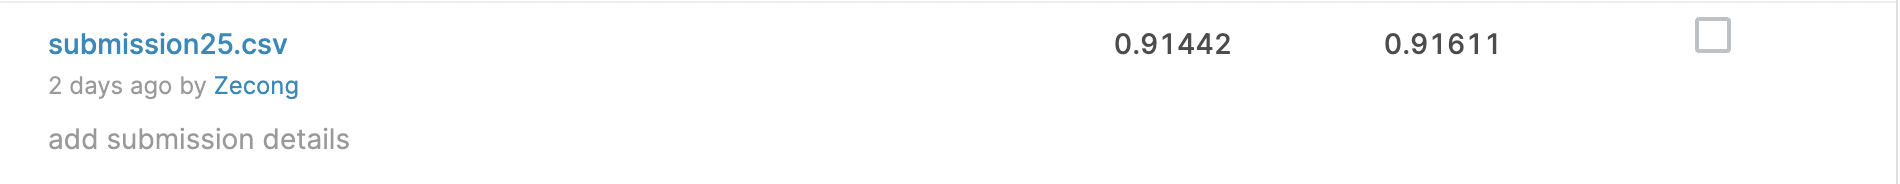

In [ ]:
#features = [x for x in X_train.columns if x.startswith("var")]
features = X.columns[0:200].to_list()

pred = 0
for var in features:
    print(var)
    model_1 = CatBoostClassifier(scale_pos_weight=1/11)
    #model_1 = LogisticRegression(class_weight='balanced',solver='newton-cg',verbose=1)
    
    model_2 = xgb.XGBClassifier()
    #model_3 = RandomForestClassifier(n_estimators=250, min_samples_split=20)
    model_4 = LGBMClassifier()
    
    var_count_name = var + '_unique'
    all_models = [('cat', model_1), ('xgb', model_2), ('lgbm', model_4)]
    #all_models = [('lr', model_1), ('xgb', model_2), ('rf', model_3), ('lgbm', model_4)]
     # create meta model
    final_lr = LogisticRegression(class_weight='balanced', solver='newton-cg')

    # stacked model
    stack = StackingClassifier(estimators=all_models,
                           final_estimator=final_lr,
                           cv=None,
                           stack_method='predict_proba',
                           n_jobs=-1,
                           passthrough=True, # Train final model on predictions and base data
                           verbose=1)
    
    model = stack.fit(np.hstack([X[var].values.reshape(-1, 1),
                      X[var_count_name].values.reshape(-1, 1)]), Y.values)
    #print(model.predict_proba(np.hstack([X_test[var].values.reshape(-1, 1),X_test[var_count_name].values.reshape(-1, 1)]))[:, 1])

    val_pred += model.predict_proba(np.hstack([X_val[var].values.reshape(-1, 1),
                  X_val[var_count_name].values.reshape(-1, 1)]))[:, 1]
    val_pred_prob = val_pred/200
    pred += model.predict_proba(np.hstack([X_test[var].values.reshape(-1, 1),
                  X_test[var_count_name].values.reshape(-1, 1)]))[:, 1]
    #pred_prob = pred/200

In [ ]:
b = pd.DataFrame({"ID_code": test['ID_code'], "target": pred/200})

In [ ]:
b.to_csv("submission25.csv", index = False) 

## Business Value Analysis

### draw ROC curve on validation dataset

In [23]:
fpr, tpr, thresholds = metrics.roc_curve(Y_val, val_pred_prob, pos_label=1)
auc_score = round(metrics.auc(fpr, tpr), 4)
print('AUC score:', auc_score)

AUC score: 0.9138


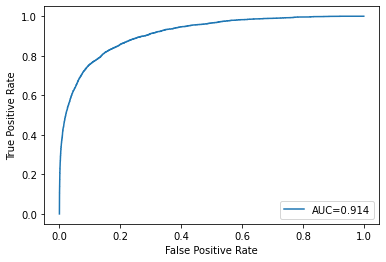

In [16]:
auc = metrics.roc_auc_score(Y_val, val_pred_prob)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [102]:
cost_matrix = np.array([[10, -100], [-20, 100]])

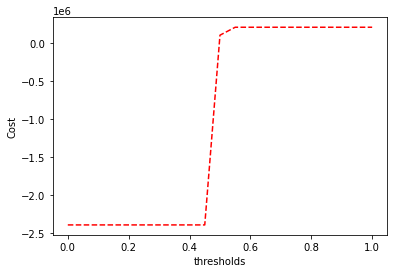

Minimal cost is: -2394800.0 with using threshold 0.0


In [103]:
Cost_List=np.linspace(0, 1.0, num=21)
thresholds = np.linspace(0, 1.0, num=21)
index=0

for t in thresholds:
    predict_thre = np.where(val_pred_prob > t, 1, 0)  ##prediction based on the preset threshold
    clf_matrix = confusion_matrix(Y_val, predict_thre)
    Cost_List[index] = clf_matrix[0][0]*cost_matrix[0][0]+clf_matrix[0][1]*cost_matrix[0][1]+clf_matrix[1][0]*cost_matrix[1][0]+clf_matrix[1][1]*cost_matrix[1][1]
    index+=1
    #print(predict_thre)
#y_pred = np.where(y_pred_prob>=0.5, 1, 0)
plt.figure(1)
plt.plot(thresholds, Cost_List, 'r--')
plt.xlabel("thresholds")
plt.ylabel("Cost")
plt.show()

cost_tb = pd.DataFrame({'threshold':thresholds, 'cost':Cost_List}).sort_values('cost')
min_thres = cost_tb['threshold'].iloc[0]
min_cost = cost_tb['cost'].iloc[0]

print('Minimal cost is: {} with using threshold {}'.format(min_cost, min_thres))